## Dependencies

In [1]:
from openvaccine_scripts import *
import warnings, json
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


SEED = 0
seed_everything(SEED)
warnings.filterwarnings('ignore')

# Model parameters

In [2]:
config = {
  "BATCH_SIZE": 64,
  "EPOCHS": 120,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "PB_SEQ_LEN": 107,
  "PV_SEQ_LEN": 130,
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BATCH_SIZE': 64,
 'EPOCHS': 120,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'PB_SEQ_LEN': 107,
 'PV_SEQ_LEN': 130}

# Load data

In [3]:
database_base_path = '/kaggle/input/stanford-covid-vaccine/'
train = pd.read_json(database_base_path + 'train.json', lines=True)
test = pd.read_json(database_base_path + 'test.json', lines=True)

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 2400


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


Test samples: 3634


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Auxiliary functions

In [4]:
def get_dataset(x, y=None, sample_weights=None, labeled=True, shuffled=True, batch_size=32, buffer_size=-1, seed=0):
    input_map = {'inputs_seq': x['sequence'], 
                 'inputs_struct': x['structure'], 
                 'inputs_loop': x['predicted_loop_type'], 
                 'inputs_bpps_max': x['bpps_max'], 
                 'inputs_bpps_sum': x['bpps_sum'], 
                 'inputs_bpps_mean': x['bpps_mean'], 
                 'inputs_bpps_scaled': x['bpps_scaled']}
    
    if labeled:
        output_map = {'output_react': y['reactivity'], 
                      'output_bg_ph': y['deg_Mg_pH10'], 
                      'output_ph': y['deg_pH10'], 
                      'output_mg_c': y['deg_Mg_50C'], 
                      'output_c': y['deg_50C']}
        if sample_weights is not None:
            dataset = tf.data.Dataset.from_tensor_slices((input_map, output_map, sample_weights))
        else:
            dataset = tf.data.Dataset.from_tensor_slices((input_map, output_map))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((input_map))
    
    if shuffled:
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size)
    
    return dataset

# Model

In [5]:
def model_fn(hidden_dim=384, dropout=.5, pred_len=68, n_outputs=5):
    inputs_seq  = L.Input(shape=(None, 1), name='inputs_seq')  
    inputs_struct  = L.Input(shape=(None, 1), name='inputs_struct')  
    inputs_loop  = L.Input(shape=(None, 1), name='inputs_loop')
    inputs_bpps_max  = L.Input(shape=(None, 1), name='inputs_bpps_max')
    inputs_bpps_sum  = L.Input(shape=(None, 1), name='inputs_bpps_sum')
    inputs_bpps_mean  = L.Input(shape=(None, 1), name='inputs_bpps_mean')
    inputs_bpps_scaled  = L.Input(shape=(None, 1), name='inputs_bpps_scaled')

    def _one_hot(x, num_classes):
        return K.squeeze(K.one_hot(K.cast(x, 'uint8'), num_classes=num_classes), axis=2)

    ohe_seq = L.Lambda(_one_hot, arguments={'num_classes': len(token2int_seq)}, input_shape=(None, 1))(inputs_seq)
    ohe_struct = L.Lambda(_one_hot, arguments={'num_classes': len(token2int_struct)}, input_shape=(None, 1))(inputs_struct)
    ohe_loop = L.Lambda(_one_hot, arguments={'num_classes': len(token2int_loop)}, input_shape=(None, 1))(inputs_loop)
    
    ### Encoder block
    # Conv block
    conv_seq =         L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(ohe_seq)
    conv_struct =      L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(ohe_struct)
    conv_loop =        L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(ohe_loop)
    conv_bpps_max =    L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(inputs_bpps_max)
    conv_bpps_sum =    L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(inputs_bpps_sum)
    conv_bpps_mean =   L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(inputs_bpps_mean)
    conv_bpps_scaled = L.Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(inputs_bpps_scaled)
    
    x_concat = L.concatenate([conv_seq, conv_struct, conv_loop, conv_bpps_max, 
                              conv_bpps_sum, conv_bpps_mean, conv_bpps_scaled], axis=-1, name='conv_concatenate')

    # Recurrent block
    encoder, encoder_state_f, encoder_state_b = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, 
                                                                      return_state=True, kernel_initializer='orthogonal'), 
                                                                name='Encoder_RNN')(x_concat)
        
    
    ### Decoder block
    decoder = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'), 
                              name='Decoder')(encoder, initial_state=[encoder_state_f, encoder_state_b])
    
    # Attention
    attention = L.AdditiveAttention()([encoder, decoder])
    attention = L.concatenate([attention, decoder])
    
    # Since we are only making predictions on the first part of each sequence, we have to truncate it
    decoder_truncated = attention[:, :pred_len]
    
    output_react = L.Dense(1, name='output_react')(decoder_truncated)
    output_bg_ph = L.Dense(1, name='output_bg_ph')(decoder_truncated)
    output_ph = L.Dense(1, name='output_ph')(decoder_truncated)
    output_mg_c = L.Dense(1, name='output_mg_c')(decoder_truncated)
    output_c = L.Dense(1, name='output_c')(decoder_truncated)
    
    
    model = Model(inputs=[inputs_seq, inputs_struct, inputs_loop, inputs_bpps_max, 
                          inputs_bpps_sum, inputs_bpps_mean, inputs_bpps_scaled], 
                  outputs=[output_react, output_bg_ph, output_ph, output_mg_c, output_c])

    opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    model.compile(optimizer=opt, loss={'output_react': MCRMSE, 
                                       'output_bg_ph': MCRMSE, 
                                       'output_ph': MCRMSE, 
                                       'output_mg_c': MCRMSE, 
                                       'output_c': MCRMSE},
                                 loss_weights={'output_react': 2., 
                                               'output_bg_ph': 2., 
                                               'output_ph': 1., 
                                               'output_mg_c': 2., 
                                               'output_c': 1.})

    return model

model = model_fn()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_seq (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_struct (InputLayer)      [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_loop (InputLayer)        [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, 4)      0           inputs_seq[0][0]                 
_______________________________________________________________________________________

# Pre-process

In [6]:
# Add bpps as features
bpps_max = []
bpps_sum = []
bpps_mean = []
bpps_scaled = []
bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
bpps_nb_std = 0.08914   # std of bpps_nb across all training data
for row in train.itertuples():
    probability = np.load(f'{database_base_path}/bpps/{row.id}.npy')
    bpps_max.append(probability.max(-1).tolist())
    bpps_sum.append((1-probability.sum(-1)).tolist())
    bpps_mean.append((1-probability.mean(-1)).tolist())
    # bpps nb
    bpps_nb = (probability > 0).sum(axis=0) / probability.shape[0]
    bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
    bpps_scaled.append(bpps_nb)
train = train.assign(bpps_max=bpps_max, bpps_sum=bpps_sum, bpps_mean=bpps_mean, bpps_scaled=bpps_scaled)

bpps_max = []
bpps_sum = []
bpps_mean = []
bpps_scaled = []
for row in test.itertuples():
    probability = np.load(f'{database_base_path}/bpps/{row.id}.npy')
    bpps_max.append(probability.max(-1).tolist())
    bpps_sum.append((1-probability.sum(-1)).tolist())
    bpps_mean.append((1-probability.mean(-1)).tolist())
    # bpps nb
    bpps_nb = (probability > 0).sum(axis=0) / probability.shape[0]
    bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
    bpps_scaled.append(bpps_nb)
test = test.assign(bpps_max=bpps_max, bpps_sum=bpps_sum, bpps_mean=bpps_mean, bpps_scaled=bpps_scaled)


feature_cols = ['sequence', 'structure', 'predicted_loop_type', 'bpps_max', 'bpps_sum', 'bpps_mean', 'bpps_scaled']
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
encoder_list = [token2int_seq, token2int_struct, token2int_loop, None, None, None, None]

public_test = test.query("seq_length == 107").copy()
private_test = test.query("seq_length == 130").copy()

x_test_public = get_features_dict(public_test, feature_cols, encoder_list, public_test.index)
x_test_private = get_features_dict(private_test, feature_cols, encoder_list, private_test.index)

# To use as stratified col
train['signal_to_noise_int'] = train['signal_to_noise'].astype(int)

# Training

In [7]:
AUTO = tf.data.experimental.AUTOTUNE
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
history_list = []

oof = train[['id', 'SN_filter', 'signal_to_noise'] + pred_cols].copy()
oof_preds = np.zeros((len(train), 68, len(pred_cols)))
test_public_preds = np.zeros((len(public_test), config['PB_SEQ_LEN'], len(pred_cols)))
test_private_preds = np.zeros((len(private_test), config['PV_SEQ_LEN'], len(pred_cols)))

for fold,(train_idx, valid_idx) in enumerate(skf.split(train['signal_to_noise_int'])):
    if fold >= config['N_USED_FOLDS']:
        break
    print(f'\nFOLD: {fold+1}')
    
    ### Create datasets
    x_train = get_features_dict(train, feature_cols, encoder_list, train_idx)
    x_valid = get_features_dict(train, feature_cols, encoder_list, valid_idx)
    y_train = get_targets_dict(train, pred_cols, train_idx)
    y_valid = get_targets_dict(train, pred_cols, valid_idx)
    w_train = np.log(train.iloc[train_idx]['signal_to_noise'].values+1.2)+1
    w_valid = np.log(train.iloc[valid_idx]['signal_to_noise'].values+1.2)+1
    
    
    train_ds = get_dataset(x_train, y_train, w_train, labeled=True, shuffled=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    valid_ds = get_dataset(x_valid, y_valid, w_valid, labeled=True, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    oof_ds = get_dataset(get_features_dict(train, feature_cols, encoder_list, valid_idx), labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_public_ds = get_dataset(x_test_public, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_private_ds = get_dataset(x_test_private, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)


    ### Model
    K.clear_session()
    model = model_fn()

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], restore_best_weights=True, verbose=1)
    rlrp = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, verbose=1)
    
    ### Train
    history = model.fit(train_ds,
                        validation_data=valid_ds,
                        callbacks=[es, rlrp],
                        epochs=config['EPOCHS'],
                        batch_size=config['BATCH_SIZE'],
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    ### Inference
    oof_ds_preds = np.array(model.predict(oof_ds)).reshape((len(pred_cols), len(valid_idx), 68)).transpose((1, 2, 0))
    oof_preds[valid_idx] = oof_ds_preds
    
    # Short sequence (public test)
    model = model_fn(pred_len=config['PB_SEQ_LEN'])
    model.load_weights(model_path)
    test_public_ds_preds = np.array(model.predict(test_public_ds)).reshape((len(pred_cols), len(public_test), 
                                                                            config['PB_SEQ_LEN'])).transpose((1, 2, 0))
    test_public_preds += test_public_ds_preds * (1 / config['N_USED_FOLDS'])
    
    # Long sequence (private test)
    model = model_fn(pred_len=config['PV_SEQ_LEN'])
    model.load_weights(model_path)
    test_private_ds_preds = np.array(model.predict(test_private_ds)).reshape((len(pred_cols), len(private_test), 
                                                                              config['PV_SEQ_LEN'])).transpose((1, 2, 0))
    test_private_preds += test_private_ds_preds * (1 / config['N_USED_FOLDS'])


FOLD: 1
Epoch 1/120
30/30 - 8s - loss: 10.9584 - output_react_loss: 1.3379 - output_bg_ph_loss: 1.4138 - output_ph_loss: 1.5275 - output_mg_c_loss: 1.2974 - output_c_loss: 1.3327 - val_loss: 8.6224 - val_output_react_loss: 0.9020 - val_output_bg_ph_loss: 1.1353 - val_output_ph_loss: 1.2658 - val_output_mg_c_loss: 1.1093 - val_output_c_loss: 1.0634
Epoch 2/120
30/30 - 6s - loss: 8.8125 - output_react_loss: 0.9295 - output_bg_ph_loss: 1.1374 - output_ph_loss: 1.3131 - output_mg_c_loss: 1.1224 - output_c_loss: 1.1206 - val_loss: 7.9603 - val_output_react_loss: 0.8300 - val_output_bg_ph_loss: 1.0404 - val_output_ph_loss: 1.1672 - val_output_mg_c_loss: 1.0226 - val_output_c_loss: 1.0070
Epoch 3/120
30/30 - 6s - loss: 8.3297 - output_react_loss: 0.8834 - output_bg_ph_loss: 1.0654 - output_ph_loss: 1.2432 - output_mg_c_loss: 1.0572 - output_c_loss: 1.0745 - val_loss: 7.6910 - val_output_react_loss: 0.7998 - val_output_bg_ph_loss: 0.9979 - val_output_ph_loss: 1.1340 - val_output_mg_c_loss: 0.

## Model loss graph


FOLD: 1
Train 5.16135 Validation 5.45007

FOLD: 2
Train 4.88432 Validation 6.10502

FOLD: 3
Train 4.80217 Validation 5.61322

FOLD: 4
Train 4.85491 Validation 5.74793

FOLD: 5
Train 4.25609 Validation 6.03953


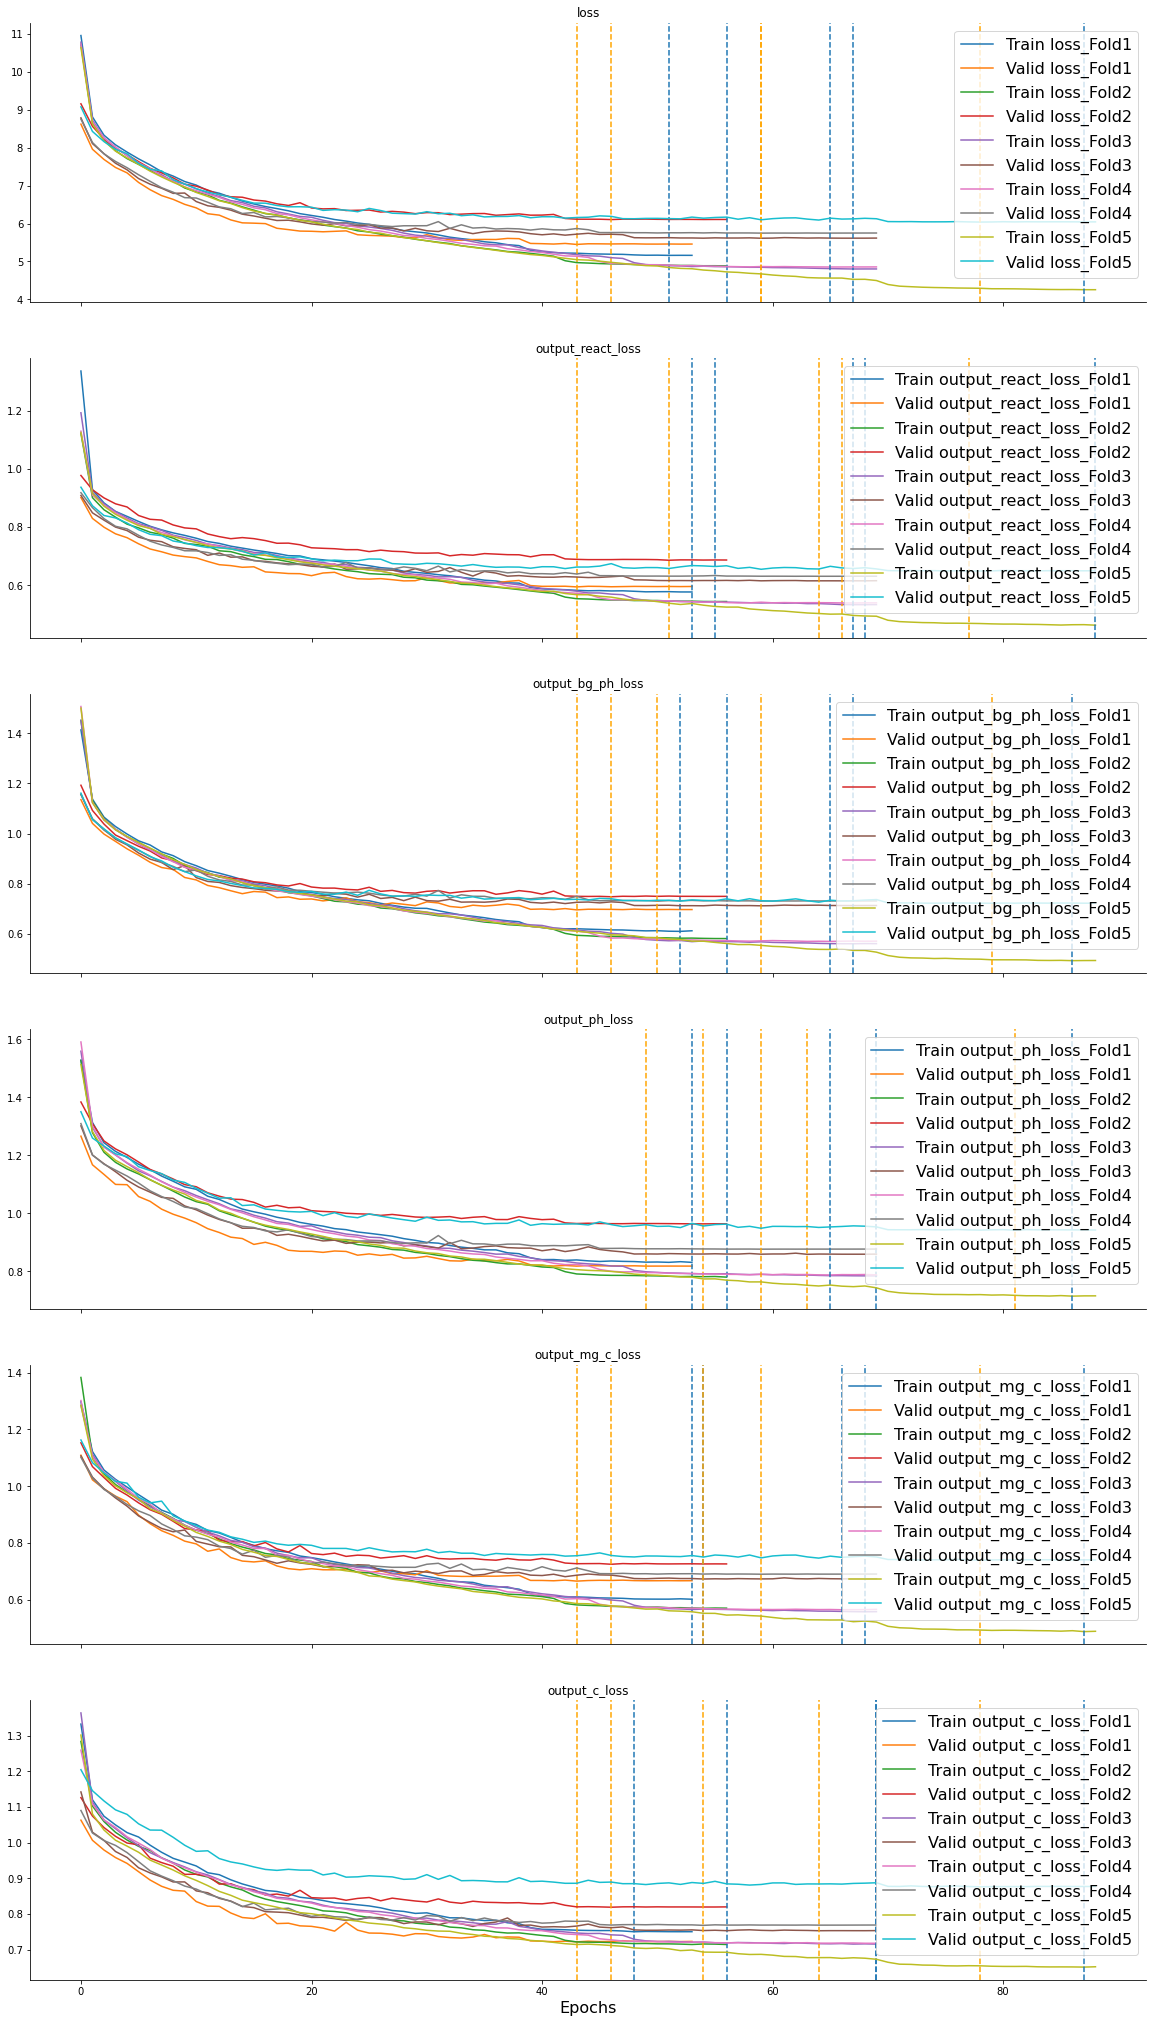

In [8]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    print(f"Train {np.array(history['loss']).min():.5f} Validation {np.array(history['val_loss']).min():.5f}")

plot_metrics_agg(history_list)

# Post-processing

In [9]:
# Assign preds to OOF set
for idx, col in enumerate(pred_cols):
    val = oof_preds[:, :, idx]
    oof = oof.assign(**{f'{col}_pred': list(val)})
    
oof.to_csv('oof.csv', index=False)

oof_preds_dict = {}
for col in pred_cols:
    oof_preds_dict[col] = oof_preds[:, :, idx]

# Assign values to test set
preds_ls = []

for df, preds in [(public_test, test_public_preds), (private_test, test_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

# Model evaluation

In [10]:
y_true_dict = get_targets_dict(train, pred_cols, train.index)
y_true = np.array([y_true_dict[col] for col in pred_cols]).transpose((1, 2, 0, 3)).reshape(oof_preds.shape)

display(evaluate_model(train, y_true, oof_preds, pred_cols))

,Metric/MCRMSE,Complete,Clean (SN),Noisy (SN),Clean (signal),Noisy (signal)
0,Overall,0.819577,0.220556,1.371254,0.234977,2.210312
1,reactivity,0.604026,0.202122,0.999827,0.206990,1.607785
2,deg_Mg_pH10,0.541928,0.253113,0.862311,0.253944,1.368921
3,deg_pH10,1.171516,0.237168,1.987787,0.260937,3.219579
4,deg_Mg_50C,0.733154,0.207663,1.227265,0.221357,1.976285
5,deg_50C,1.047261,0.202713,1.779080,0.231655,2.878991


# Visualize test predictions

In [11]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission = submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])

# Test set predictions

In [12]:
display(submission.head(10))
display(submission.describe())

submission.to_csv('submission.csv', index=False)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.670840,0.609187,2.139270,0.509005,0.753007
1,id_00073f8be_1,2.057575,2.919042,4.243849,2.958698,2.737048
2,id_00073f8be_2,1.511477,0.548332,0.716668,0.718556,0.753690
3,id_00073f8be_3,1.284745,0.937472,1.113123,1.468313,1.707190
4,id_00073f8be_4,0.801031,0.496780,0.435130,0.775681,0.828761
5,id_00073f8be_5,0.753831,0.425341,0.512170,0.650220,0.724164
6,id_00073f8be_6,0.827342,0.921830,0.944577,1.027112,0.984343
7,id_00073f8be_7,0.950025,1.059088,1.301624,1.080585,1.430962
8,id_00073f8be_8,0.181236,0.635252,0.625292,0.776910,0.568685
9,id_00073f8be_9,0.112030,0.250963,0.285236,0.329052,0.424715


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
count,457953.000000,457953.000000,457953.000000,457953.000000,457953.000000
mean,0.327849,0.410067,0.392021,0.334300,0.356712
std,0.364834,0.396012,0.431620,0.387916,0.337638
min,-0.332800,-0.949823,-2.203796,-1.923725,-1.827283
25%,0.077028,0.184423,0.152472,0.093420,0.120821
50%,0.198965,0.300379,0.296722,0.240127,0.296167
75%,0.459351,0.503177,0.489056,0.462798,0.520850
max,3.682931,5.200889,5.890788,4.241211,3.657732
